# DFL benchmark - training
This is a simple benchmark script for DFL.  
It classifies each frame image in the video into 4 classes（'background','challenge','play','throwin'） 
It does not use temporal information, so it may not be competitive on its own for this competition, but it could be used as a feature extractor for more advanced models.

In [1]:
!nvidia-smi

Wed Sep 14 23:46:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   36C    P8    36W / 350W |    672MiB / 24576MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import Video
import cv2

# setting

In [3]:
DEBUG = True

In [4]:
class CFG:
    train_csv = "/workdir/work/input/train.csv"
    result_dir = f"/workdir/work/output/train_images/"
    arround_time = 1
    video_dir = "/workdir/work/input/train"

    # optical flow settings
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                        qualityLevel = 0.3,
                        minDistance = 7,
                        blockSize = 7 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                    maxLevel = 2,
                    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    WIDTH = 1920
    HEIGHT = 1080
    crop_range = 600
    area_thr = 0.1
    flow_num = 5

In [5]:
video_path = "/workdir/work/input/train/3c993bd2_0.mp4"
cap = cv2.VideoCapture(video_path)

In [6]:
def crop_maxflow_area(x, y, width, height, crop_range=CFG.crop_range):
    crop_x_min = int(x) - (crop_range/2)
    crop_x_max = int(x) + (crop_range/2)
    crop_x_min = max(0, crop_x_min)
    crop_x_max = min(width, crop_x_max)
    # if crop_x_min < 0:
    #     crop_x_min += abs(crop_x_min)
    #     crop_x_max += abs(crop_x_min)
    # if crop_x_max > width:
    #     crop_x_min -= (crop_x_max - width)
    #     crop_x_max -= (crop_x_max - width)

    crop_y_min = int(y) - (crop_range/2)
    crop_y_max = int(y) + (crop_range/2)
    crop_y_min = max(0, crop_y_min)
    crop_y_max = min(height, crop_y_max)
    # if crop_y_min < 0:
    #     crop_y_min += abs(crop_y_min)
    #     crop_y_max += abs(crop_y_min)
    # elif crop_y_max > width:
    #     crop_y_min -= (crop_y_max - height)
    #     crop_y_max -= (crop_y_max - height)

    return int(crop_x_min), int(crop_x_max), int(crop_y_min), int(crop_y_max)

In [7]:
def get_green_area(img):
    # HSV
    # img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # creat green mask (H value for green is from 100/360*179 until 180/360*179) in OpenCV
    lower_green = np.array([100 / 360 * 179, 0, 0])
    upper_green = np.array([180 / 360 * 179, 255, 255])
    green_mask = cv2.inRange(img_HSV, lower_green, upper_green)

    # print(green_mask)
    # crop green area
    img_green_masked = cv2.bitwise_and(img, img, mask=green_mask)
    # print(img_green_masked)
    img_green_masked = cv2.cvtColor(img_green_masked, cv2.COLOR_BGR2GRAY)
    # Find contours
    # cnts = cv2.findContours(img_green_masked, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours, hierarchy = cv2.findContours(img_green_masked, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)    
    # Find the contour with the maximum area.
    c = max(contours, key=cv2.contourArea)

    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(c)

    # Crop the bounding rectangle out of img
    # croped_img = img[y:y+h, x:x+w, :].copy()

    return x, y, w, h

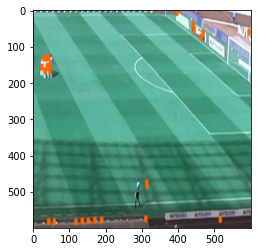

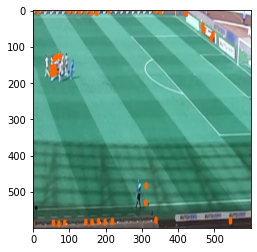

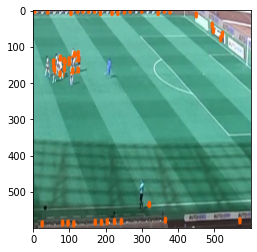

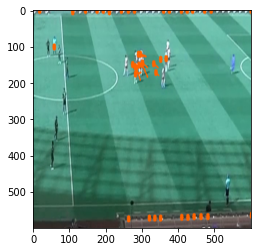

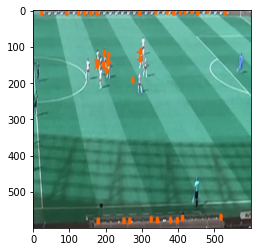

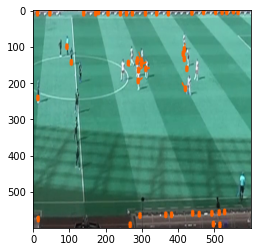

In [8]:
fps = cap.get(cv2.CAP_PROP_FPS)
time_interval = 1/fps
frame_num = 0


# Create some random colors
# color = np.random.randint(0,255,(100,3))
line_color = [255, 100, 0]
while True:
    successed, base_frame = cap.read()
    if frame_num < 220*25:
        frame_num+=1
        continue
    if not successed or frame_num > 220*25 + 25*5:
        break
    # base frameでフィールドの範囲を決める。1secで大きくカメラ方向が移動するときはだめかも
    x_field, y_field, w_field, h_field = get_green_area(base_frame)
    base_frame = base_frame[y_field:y_field+h_field, x_field:x_field+w_field, :]

    # Take first frame and find corners in it
    base_gray = cv2.cvtColor(base_frame, cv2.COLOR_BGR2GRAY)
    base_point = cv2.goodFeaturesToTrack(base_gray, mask = None, **CFG.feature_params)
    # Create a mask image for drawing purposes
    mask = np.zeros_like(base_frame)

    # draw the tracks
    max_distance = 0
    img_max_dist = base_frame

    # 1secで基準画像とのoptical flowが最も大きい点を残す
    for i in range(int(fps)):
        successed, relative_frame = cap.read()
        frame_num += 1

        # base frameで決めたフィールドの範囲をcrop
        relative_frame = relative_frame[y_field : y_field+h_field, x_field : x_field+w_field, :]
        relative_gray = cv2.cvtColor(relative_frame, cv2.COLOR_BGR2GRAY)

        # calculate optical flow
        relative_point, st, err = cv2.calcOpticalFlowPyrLK(base_gray, relative_gray, base_point, None, **CFG.lk_params)

        # Select good points
        good_new = relative_point[st==1]
        good_old = base_point[st==1]

        for i, (new, old) in enumerate(zip(good_new, good_old)):
            x_after, y_after = new.ravel()
            x_before, y_before = old.ravel()
            distance = np.sqrt( (x_after - x_before)**2 + (y_after - y_before)**2 )
        


            # distanceが大きい、かつ、検出点が画像の外側area_thr%にないときに移動距離が最大と判定する
            if distance > max_distance and (w_field*CFG.area_thr < x_after < w_field*(1.0 -CFG.area_thr)) and (h_field*CFG.area_thr < y_after < y_field*(1.0 - CFG.area_thr)):
                max_distance = distance
                x_max_distance = x_after
                y_max_distance = y_after
                # print((int(a),int(b)))
                # 画像にoptical flow の線を追加する(本当はtop5だけ描くとかの方がいいかも？)
                mask = cv2.line(mask, (int(x_after),int(y_after)), (int(x_before), int(y_before)), line_color, 2)
                relative_frame = cv2.line(relative_frame, (int(x_after),int(y_after)), (int(x_before), int(y_before)), line_color, 2)
                img_max_dist = cv2.circle(relative_frame, (int(x_after),int(y_after)), 5, line_color, -1)

    x_min, x_max, y_min, y_max = crop_maxflow_area(int(x_max_distance), int(y_max_distance), w_field, h_field)
    # if ((x_max - x_min) == CFG.crop_range) and ((y_max - y_min) == CFG.crop_range):
    #     croped_flow_image = frame_addflow[y_min:y_max, x_min:x_max, :]
    # elif x_max - x_min == CFG.crop_range:
    #     croped_flow_image = frame_addflow[:, x_min:x_max, :]
    # elif y_max - y_min == CFG.crop_range:
    #     croped_flow_image = frame_addflow[y_min:y_max, :, :]
    # else:
    #     croped_flow_image = frame_addflow
    croped_flow_image = img_max_dist[y_min:y_max, x_min:x_max, :]
    croped_flow_image = cv2.resize(croped_flow_image, dsize=(CFG.crop_range, CFG.crop_range))
    plt.figure()
    plt.imshow(croped_flow_image)
    plt.show()


